Import Library

In [2]:
import cv2
from cv2 import dnn_superres
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
import os
from moviepy.editor import ImageClip, ImageSequenceClip, CompositeVideoClip, AudioFileClip
from PIL import Image
import re

Define Function

Matplotlib Display Function

In [3]:
def displayProcess(images, captions) -> None:
    # Calculate the number of rows and columns needed
    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # This ensures we have enough rows for all images

    # Define the figure size based on the number of rows and columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5), facecolor="black")
    axes = axes.flatten()

    for ax, img, caption in zip(axes, images, captions):
        ax.imshow(img)
        ax.set_title(caption, fontsize=18, color="white")
        ax.axis("off")

    # Turn off any unused axes
    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

Processing Function

In [4]:
#Upscaler
def imageUpscale(img, output_path:str) -> None:
    model_path = "EDSR_Model\\EDSR_x4.pb"

    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel("edsr", 4)
    
    # Perform upscaling
    upscaled_img = sr.upsample(img)

    # Write the upscaled image
    cv2.imwrite(output_path, upscaled_img)


#Remove bg
def removeBg(image_path:str, output_path:str) -> None:
    img = cv2.imread(image_path)

    output = remove(img)

    #For displaying in Matplot purposes
    original_show = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    show = cv2.cvtColor(output, cv2.COLOR_BGRA2RGBA)

    cv2.imwrite(output_path, output)

    displayProcess([original_show, show], ["Original", "Background Removed"])


#Contrast Adjustment
def adjust_contrast(img, alpha, beta):
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted


def sharpen_image(image_path:str, output_path:str):
    # Load the image
    image = cv2.imread(image_path)
    
    # Define the sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    
    # Apply the sharpening kernel to the image
    sharpened = cv2.filter2D(image, -1, kernel)
    
    # Save the result
    cv2.imwrite(output_path, sharpened)


def remove_blue_sky_and_resize(image_path:str, output_path:str) -> None:
    # Load the image with alpha channel if it exists
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert the image to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])

    # Create a mask for the blue sky
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Invert the mask
    mask_inv = cv2.bitwise_not(mask)

    # Use the mask to remove the blue sky
    result = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_inv)

    # Create an alpha channel based on the inverted mask
    alpha_channel = mask_inv

    # Add the alpha channel to the result image
    b, g, r = cv2.split(result)
    show = cv2.merge((b, g, r, alpha_channel))
    result_rgba = cv2.merge((r, g, b, alpha_channel))

    result_rgba = cv2.resize(result_rgba, (1920, 1080))

    h, w, c = result_rgba.shape
    print(w, h, c, sep=", ")

    cv2.imwrite(output_path, result_rgba)

    displayProcess([image_rgb, hsv, mask, mask_inv, show],
                    ["Original Image", "HSV Image", "Mask", "Inverse Mask", "Result"])


def apply_color_filter(input_path, output_path, color_filter, alpha) -> None:
    # Load the image with the alpha channel
    original_image = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

    # Create a color filter
    filter_array = np.full_like(original_image, color_filter)  # (B, G, R, A)

    # Blend the filter with the image
    blended_image = cv2.addWeighted(original_image, alpha, filter_array, 1 - alpha, 0)

    #For displaying in Matplot purposes
    original_show = cv2.cvtColor(original_image, cv2.COLOR_BGRA2RGBA)
    show = cv2.cvtColor(blended_image, cv2.COLOR_BGRA2RGBA)

    # Save the modified image to verify
    cv2.imwrite(output_path, blended_image)

    displayProcess([original_show, show],
                ["Original Image", "Blended Image"])
    
    
def change_opacity(input_image:str, output_image:str, alpha:float) -> None:
    image = cv2.imread(input_image, cv2.IMREAD_UNCHANGED)

    # Get the alpha channel
    alpha_channel = image[:, :, 3]

    # Adjust the alpha channel
    alpha_channel = (alpha_channel * alpha).astype(np.uint8)

    # Update the image with the new alpha channel
    image[:, :, 3] = alpha_channel

    cv2.imwrite(output_image, image)

    displayProcess([image], ["Opacity"])
                
    
def gaussian_blur(image_path:str, output_path:str, x:float, y:float) -> None:
    # Read the image with alpha channel
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image.shape[2] == 4:  # Ensure image has an alpha channel
        # Split the image into its BGR and Alpha channels
        bgr = image[:, :, :3]
        alpha = image[:, :, 3]

        # Apply Gaussian blur to the BGR channels
        blurred_bgr = cv2.GaussianBlur(bgr, (21, 21), x, y)

        # Merge the blurred BGR channels with the original alpha channel
        blurred_image = cv2.merge((blurred_bgr, alpha))
    else:
        # If no alpha channel, just blur the image as usual
        blurred_image = cv2.GaussianBlur(image, (x, y), 0)

    # Convert the images to RGB for displaying in matplotlib
    original_show = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    show = cv2.cvtColor(blurred_image, cv2.COLOR_BGRA2RGBA)

    # Save the result
    cv2.imwrite(output_path, blurred_image)

    displayProcess([original_show, show],
                   ["Original Image", "After Gaussian Blur Filter"])
    
    
def create_transparent_background(width, height):
    # Create a transparent background image with the given width and height
    return np.zeros((height, width, 4), dtype=np.uint8)


def overlay_images(background, overlay, x, y):
    h, w, _ = overlay.shape

    # Determine the region of interest in the background
    y1, y2 = max(0, y), min(y + h, background.shape[0])
    x1, x2 = max(0, x), min(x + w, background.shape[1])

    # Determine the region of interest in the overlay
    overlay_y1, overlay_y2 = max(0, -y), min(h, background.shape[0] - y)
    overlay_x1, overlay_x2 = max(0, -x), min(w, background.shape[1] - x)

    # Overlay the image onto the background
    alpha_overlay = overlay[overlay_y1:overlay_y2, overlay_x1:overlay_x2, 3] / 255.0
    alpha_background = 1.0 - alpha_overlay

    for c in range(0, 3):
        background[y1:y2, x1:x2, c] = (alpha_overlay * overlay[overlay_y1:overlay_y2, overlay_x1:overlay_x2, c] +
                                       alpha_background * background[y1:y2, x1:x2, c])
    
    # Set the alpha channel to the maximum value (255)
    background[y1:y2, x1:x2, 3] = np.maximum(background[y1:y2, x1:x2, 3], overlay[overlay_y1:overlay_y2, overlay_x1:overlay_x2, 3])

    return background


def texture_overlay(base_image_path, texture_image_path, output_path, opacity=1) -> None:
    # Read the base and texture images
    base_image = cv2.imread(base_image_path)
    texture_image = cv2.imread(texture_image_path)
    
    # Resize texture to match the base image size
    texture_image = cv2.resize(texture_image, (base_image.shape[1], base_image.shape[0]))

    # Convert images to float32 for blending
    base_image = base_image.astype(np.float32) / 255.0
    texture_image = texture_image.astype(np.float32) / 255.0

    # Blend images based on the selected blend mode
    overlay = np.where(base_image > 0.5, 1 - 2 * (1 - base_image) * (1 - texture_image), 2 * base_image * texture_image)
    blended_image = cv2.addWeighted(base_image, 1 - opacity, overlay, opacity, 0)

    # Convert blended image back to uint8
    blended_image = (blended_image * 255).astype(np.uint8)

    # Convert the images to RGB for displaying in matplotlib
    original_show = cv2.cvtColor(base_image, cv2.COLOR_BGRA2RGBA)
    texture_show = cv2.cvtColor(texture_image, cv2.COLOR_BGRA2RGBA)
    overlay_show = cv2.cvtColor(blended_image, cv2.COLOR_BGRA2RGBA)

    # Save the output image
    cv2.imwrite(output_path, overlay_show)

    displayProcess([original_show, texture_show, overlay_show],
                   ["Base Image", "Texture Image", "Overlayed"])
    

def equalize_histogram_rgb(image_path, output_path) -> None:
    # Read the image
    image = cv2.imread(image_path)
    
    # Split the image into R, G, B channels
    channels = cv2.split(image)
    
    # Apply histogram equalization to each channel
    eq_channels = []
    for ch in channels:
        eq_channels.append(cv2.equalizeHist(ch))
    
    # Merge the equalized channels back together
    eq_image = cv2.merge(eq_channels)
    
    # Save the equalized image
    cv2.imwrite(output_path, eq_image)
    
    # Plot the original and equalized histograms for comparison
    plt.figure(figsize=(12, 6))
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        # Original image histogram
        plt.subplot(2, 3, i + 1)
        plt.hist(image[:, :, i].ravel(), 256, [0, 256], color=color)
        plt.title(f'Original {color.upper()} Histogram')
        plt.xlim([0, 256])

        # Equalized image histogram
        plt.subplot(2, 3, i + 4)
        plt.hist(eq_image[:, :, i].ravel(), 256, [0, 256], color=color)
        plt.title(f'Equalized {color.upper()} Histogram')
        plt.xlim([0, 256])

    # Show the histograms
    plt.tight_layout()
    plt.show()

    # Convert the images to RGB for displaying in matplotlib
    original_show = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    eq_show = cv2.cvtColor(eq_image, cv2.COLOR_BGRA2RGBA)

    displayProcess([original_show, eq_show], ["Original", "After Histogram Equalization"])


def add_vignette(image_path:str, output_path:str, strength:int, alpha:float) -> None:
    # Read the image
    image = cv2.imread(image_path)
    rows, cols = image.shape[:2]
    
    # Create a vignette mask using Gaussian kernels
    kernel_x = cv2.getGaussianKernel(cols, strength)
    kernel_y = cv2.getGaussianKernel(rows, strength)
    kernel = kernel_y * kernel_x.T
    mask = 255 * kernel / np.linalg.norm(kernel)
    vignette = np.copy(image)
    
    # Apply the mask to each channel in the input image
    for i in range(3):
        vignette[:, :, i] = vignette[:, :, i] * mask
    
    # Blend the original image and the vignette image
    result = cv2.addWeighted(image, 1 - alpha, vignette, alpha, 0)

    result_show = cv2.cvtColor(result, cv2.COLOR_BGRA2RGBA)
    
    # Save the output image
    cv2.imwrite(output_path, result_show)

    displayProcess([image, result],
                   ["Original Picture", "After Vignette Filter"])
    

def add_text_to_image(image_path, output_path, text, position, font=cv2.FONT_HERSHEY_SIMPLEX, 
                      font_scale=1, font_color=(255, 255, 255), font_thickness=2):
    """
    Adds text to an image.
    
    :param image_path: Path to the input image.
    :param output_path: Path to save the output image.
    :param text: Text to add to the image.
    :param position: Position to add the text (x, y).
    :param font: Font type (default is cv2.FONT_HERSHEY_SIMPLEX).
    :param font_scale: Font scale (default is 1).
    :param font_color: Font color in BGR (default is white).
    :param font_thickness: Thickness of the font (default is 2).
    """
    # Read the image
    image = cv2.imread(image_path)

    # Add text to the image
    text_image = cv2.putText(image, text, position, font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)
    
    # Save the output image
    cv2.imwrite(output_path, text_image)

    # For displaying purposes
    original_show = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    show = cv2.cvtColor(text_image, cv2.COLOR_BGR2RGB)

    displayProcess([original_show, show], ["Original", "Image with text"])

Image Upscaling

In [5]:
img = cv2.imread("Original Picture\\Corner_Cyprus.jpg")
img2 = cv2.imread("Original Picture\\Beach_Cyprus.png")

imageUpscale(img, "Processed\\Upscale_Corner_Cyprus.png")
imageUpscale(img2, "Processed\\Upscale_Beach_Cyprus.png")

(-0.5, 3903.5, 2195.5, -0.5)

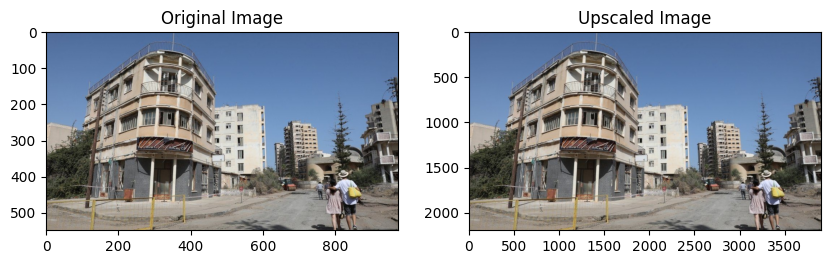

In [6]:
ori_img = cv2.imread("Original Picture\\Corner_Cyprus.jpg")
upsc_img = cv2.imread("Processed\\Upscale_Corner_Cyprus.png")

# Plot the images
plt.figure(figsize=(10, 5))

# Convert BGR to RGB
ori_img_rgb = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
upsc_img_rgb = cv2.cvtColor(upsc_img, cv2.COLOR_BGR2RGB)

# Original image
plt.subplot(1, 2, 1)
plt.imshow(ori_img_rgb)
plt.title("Original Image")
plt.axis('on')

# Upscaled image
plt.subplot(1, 2, 2)
plt.imshow(upsc_img_rgb)
plt.title("Upscaled Image")
plt.axis('on')

Editing "Forefground.png"

1920, 1080, 4


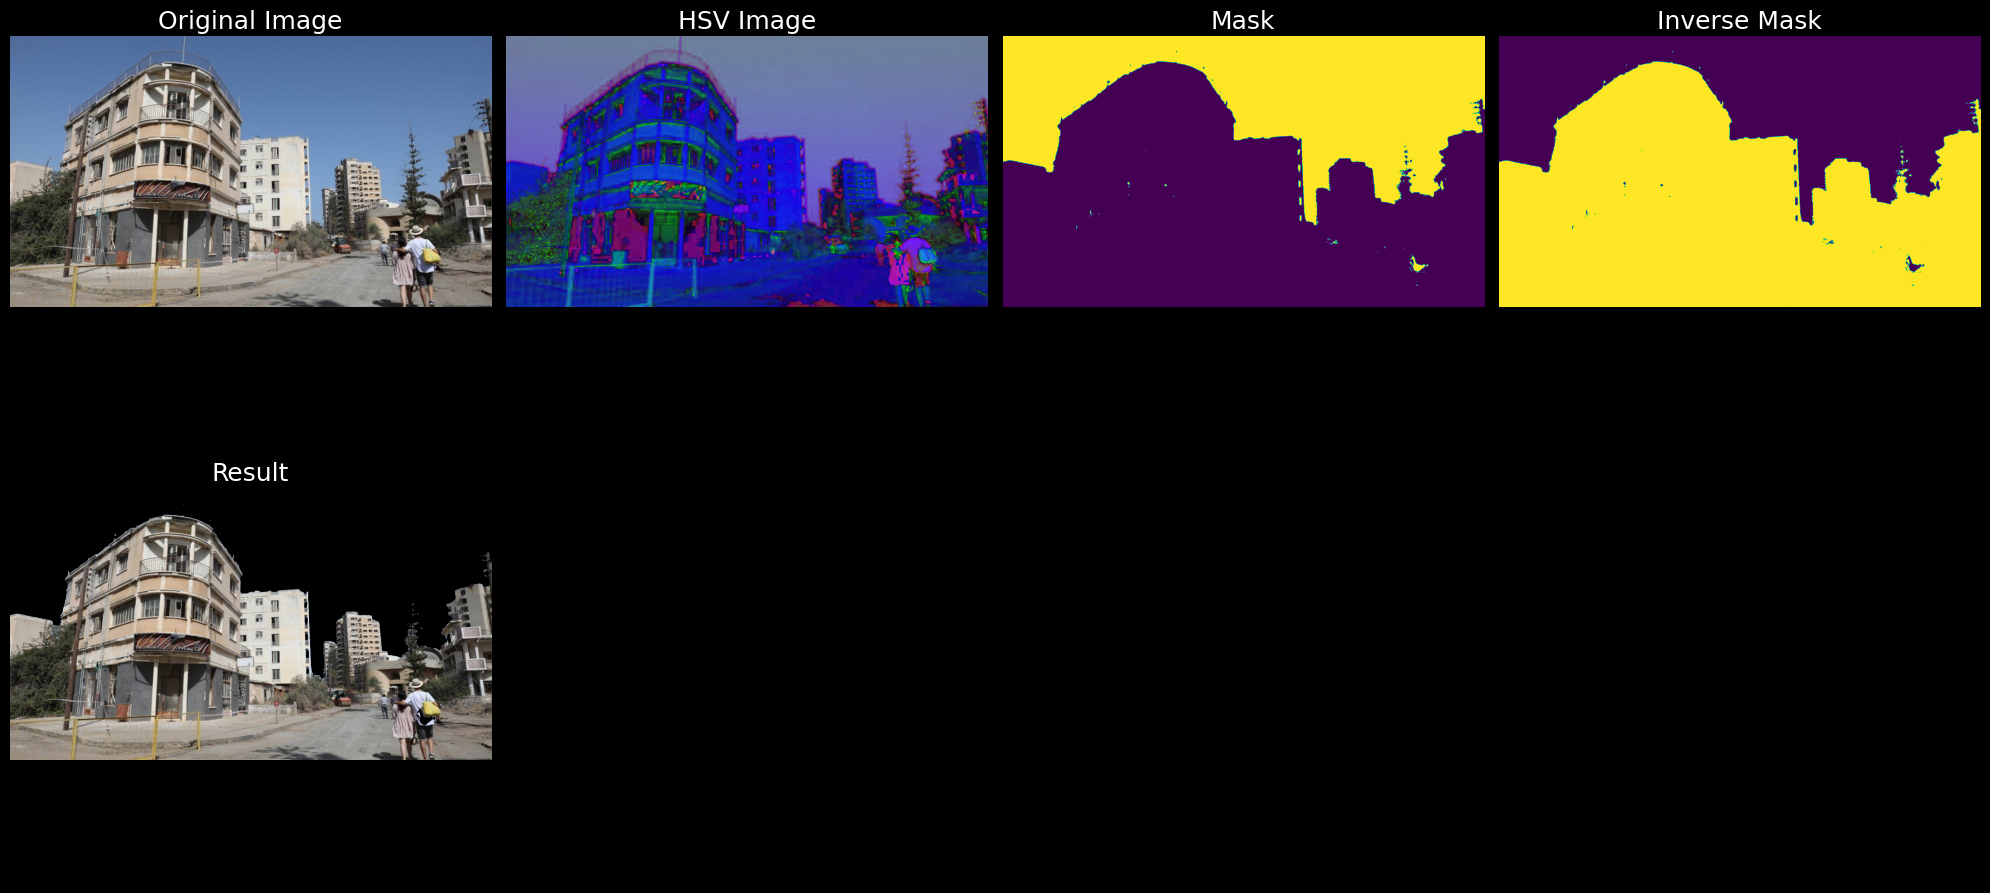

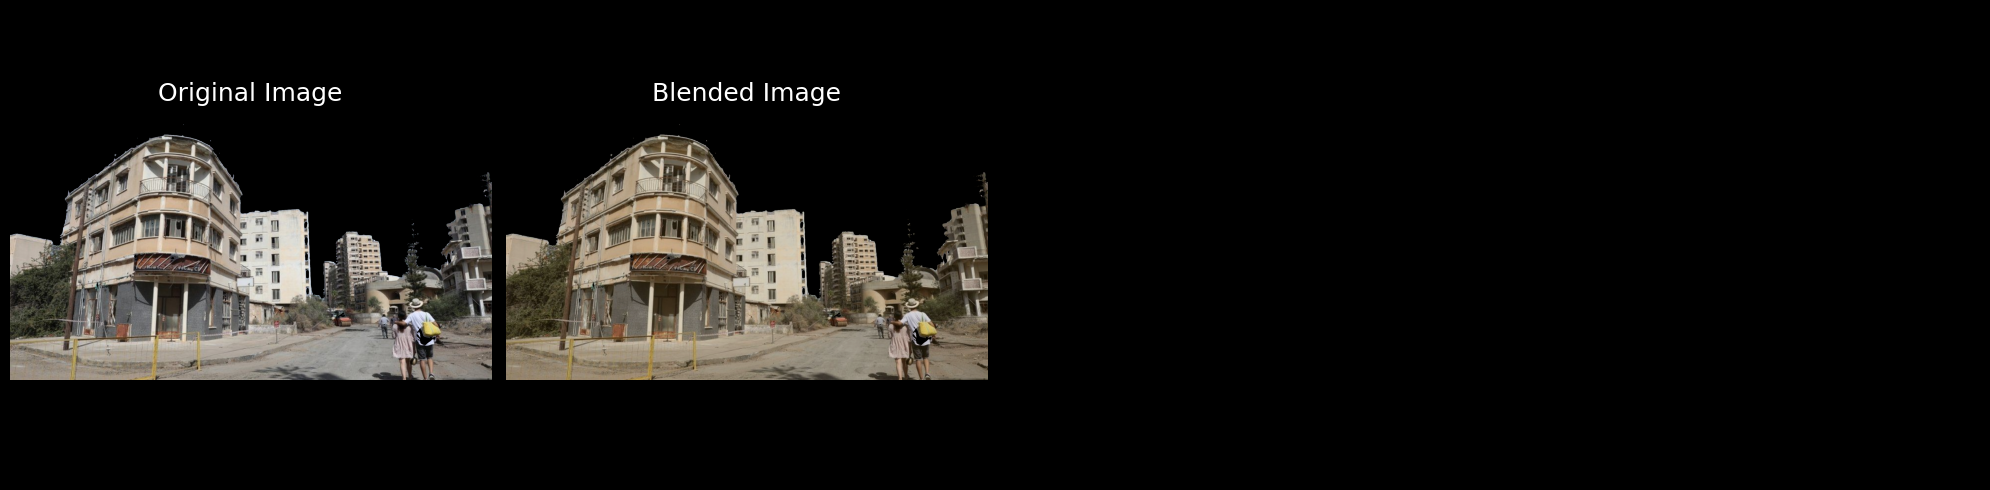

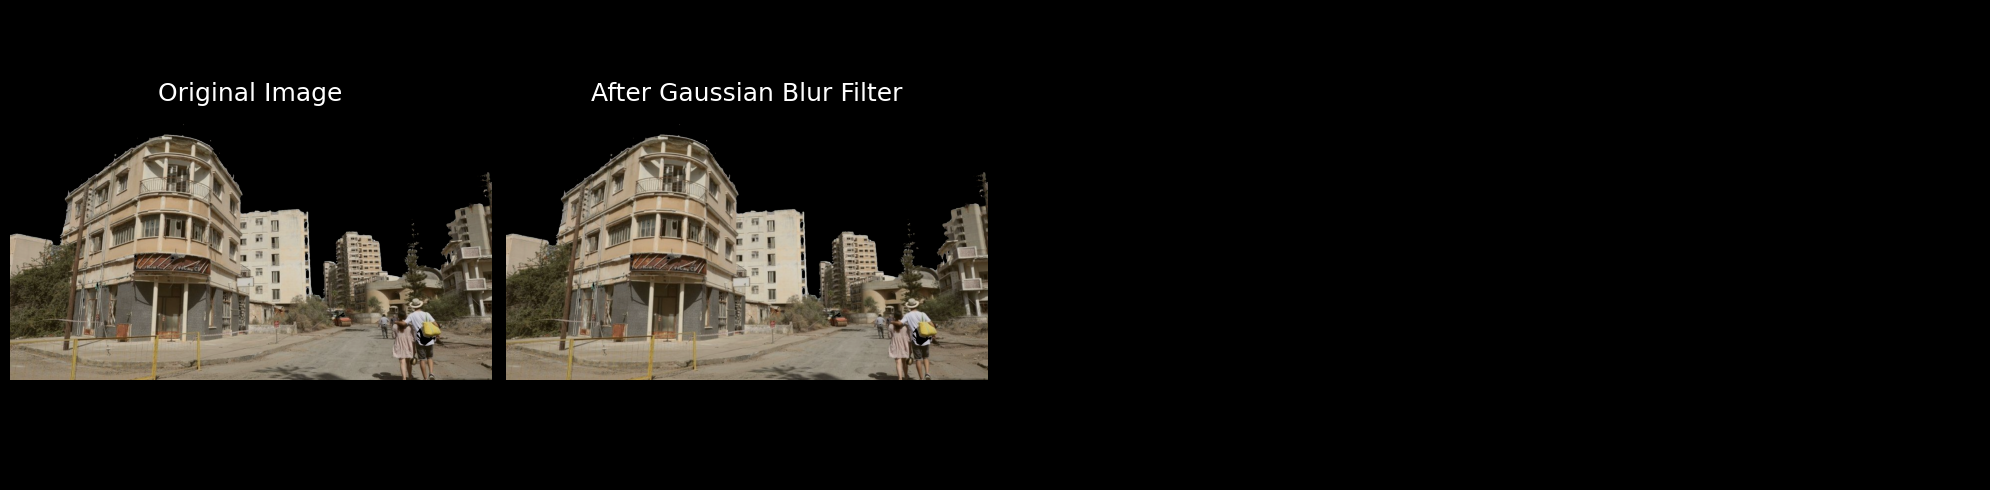

In [7]:
remove_blue_sky_and_resize("Processed\\Upscale_Corner_Cyprus.png", "Assets\\Picture1\\Foreground.png")

apply_color_filter("Assets\\Picture1\\Foreground.png", "Assets\\Picture1\\Foreground.png",
                    (0, 165, 255, 0), 0.92)

gaussian_blur("Assets\\Picture1\\Foreground.png", "Assets\\Picture1\\Foreground.png", 0.6, 0.3)

Editing "Background.png"

In [8]:
#Resizing to 1920 x 1080
background_sky = cv2.imread("Assets\\Picture1\\Background_sky.png")
background_sky = cv2.resize(background_sky, (1920, 1080))

cv2.imwrite("Assets\\Picture1\\Background_sky.png", background_sky)

h, w, c = background_sky.shape
print(w, h, c, sep=", ")

1920, 1080, 3


Editing "Shining_Effect.png"

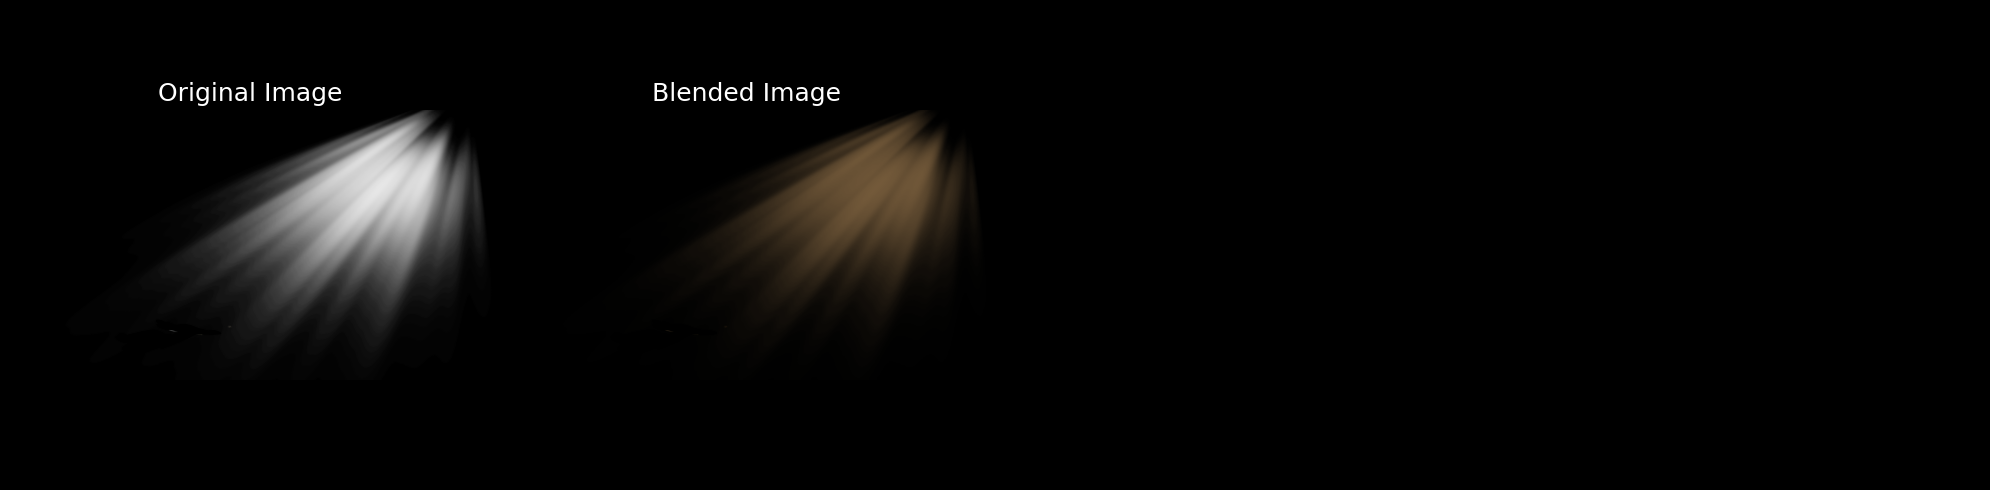

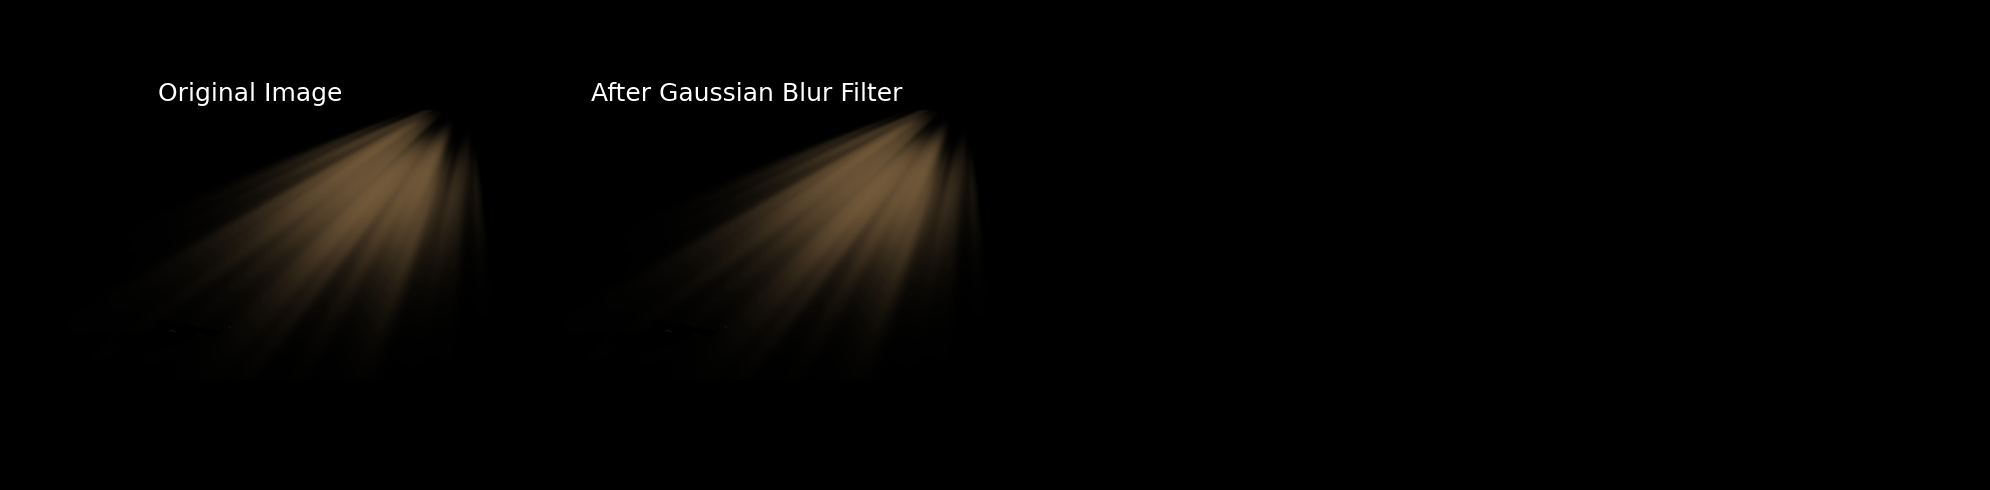

In [9]:
shinning_effect = cv2.imread("Original Picture\\Shinning_Effect.png", cv2.IMREAD_UNCHANGED)
shinning_effect = cv2.resize(shinning_effect, (1920, 1080))

cv2.imwrite("Original Picture\\Shinning_Effect.png", shinning_effect)

apply_color_filter("Original Picture\\Shinning_Effect.png", "Assets\\Picture1\\Shinning_Effect_Yellow_Orange.png",
                    (0, 140, 255, 0), 0.5)

gaussian_blur("Assets\\Picture1\\Shinning_Effect_Yellow_Orange.png", "Assets\\Picture1\\Shinning_Effect_Yellow_Orange.png", 0, 0)


Editing "Traveller.jpeg"

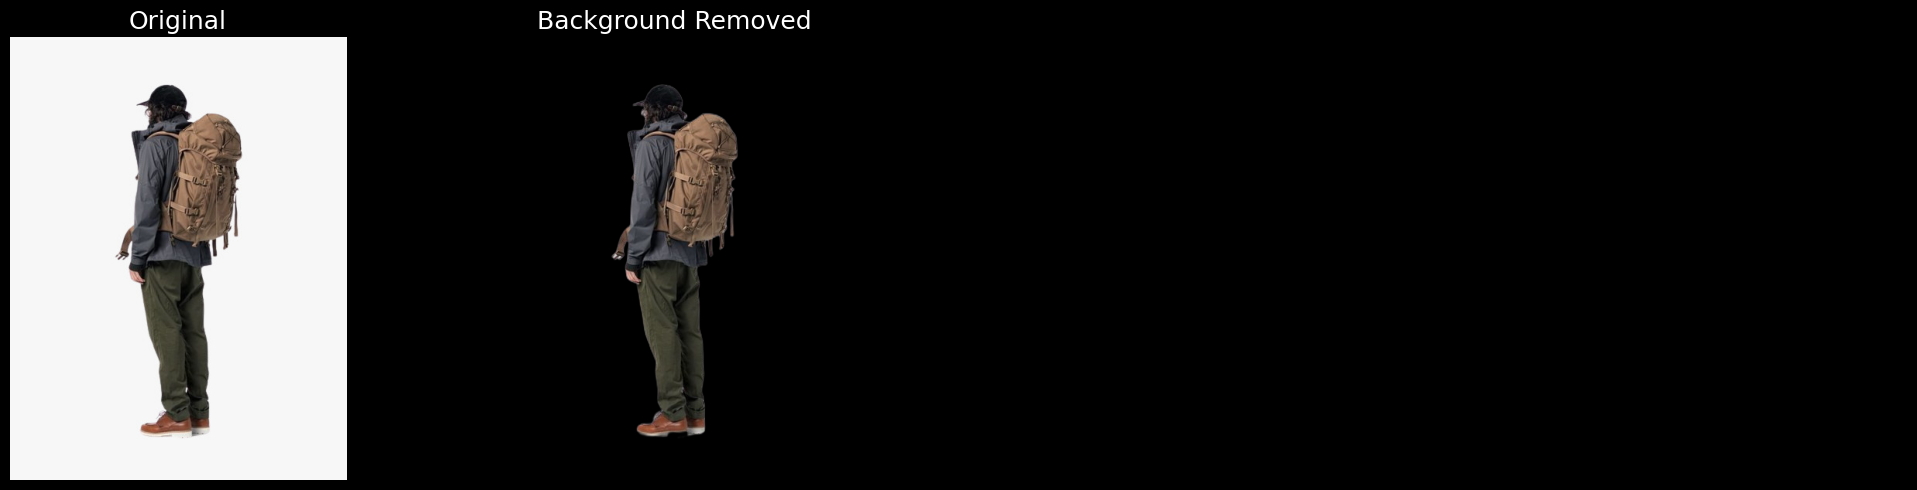

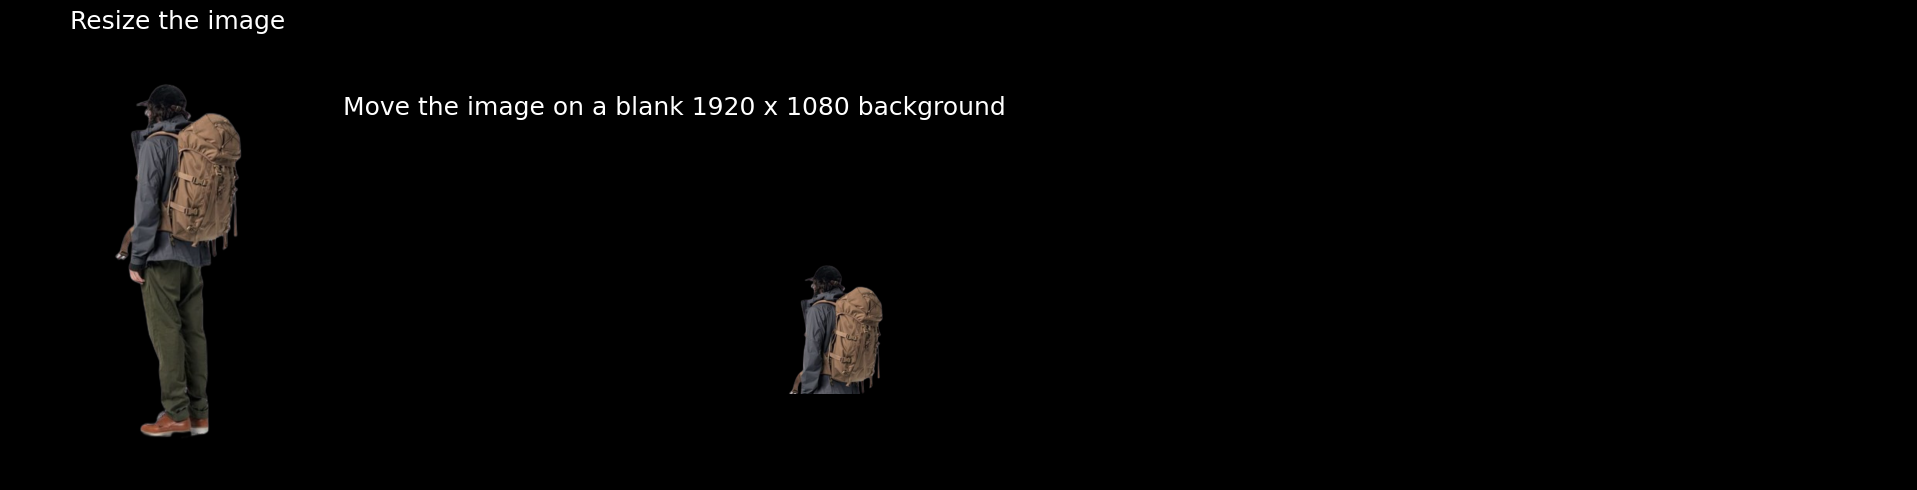

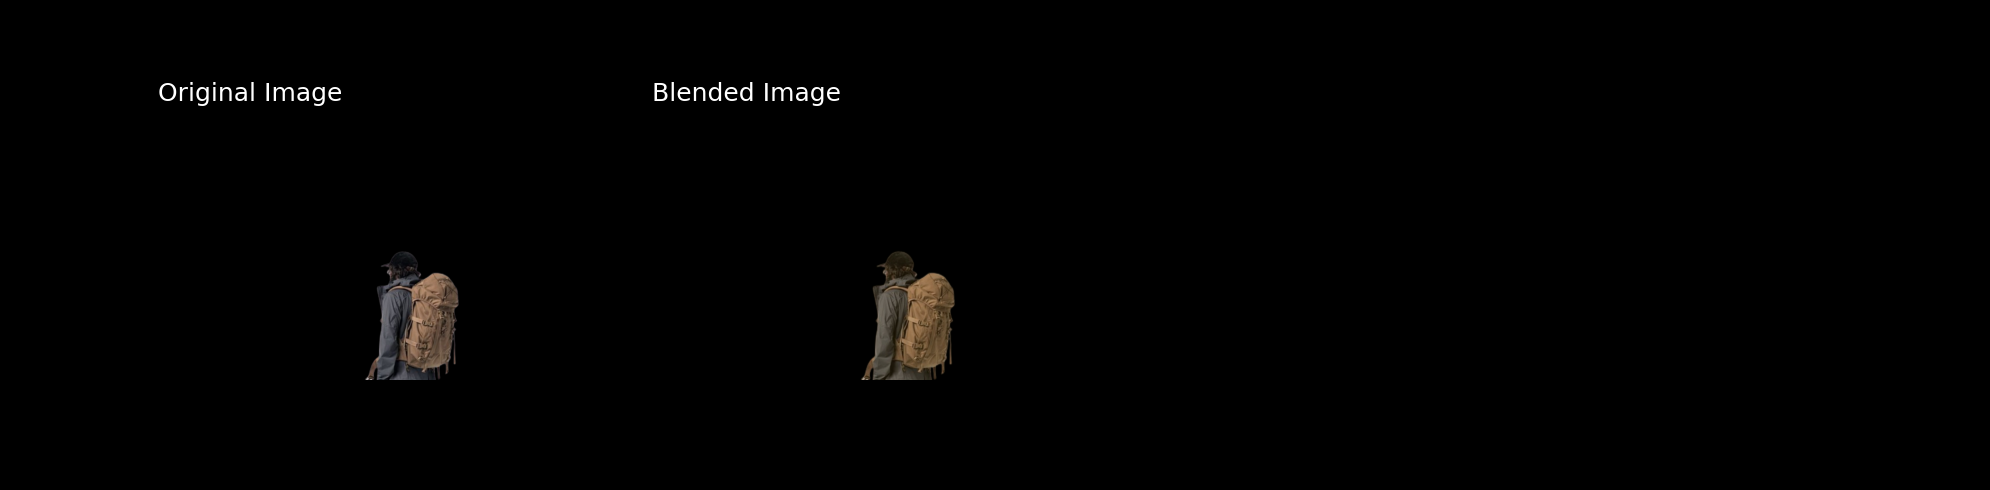

In [10]:
traveller = cv2.imread("Original Picture\\Traveller.jpeg")
flipped_traveller = cv2.flip(traveller, 1)

cv2.imwrite("Assets\\Picture1\\Traveller.png", flipped_traveller)

removeBg("Assets\\Picture1\\Traveller.png", "Assets\\Picture1\\Traveller.png")

# Create a 1920x1080 transparent background
background = create_transparent_background(1920, 1080)
overlay_img = cv2.imread("Assets\\Picture1\\Traveller.png", cv2.IMREAD_UNCHANGED)

overlay_img_resized = cv2.resize(overlay_img, (0, 0), fx=2.3, fy=2.3, interpolation=cv2.INTER_AREA)

# Overlay the image onto the background
result = overlay_images(background, overlay_img_resized, 1100, 425)

#For displaying in Matplot purposes
resized_show = cv2.cvtColor(overlay_img_resized, cv2.COLOR_BGRA2RGBA)
show = cv2.cvtColor(result, cv2.COLOR_BGRA2RGBA)

displayProcess([resized_show, show], ["Resize the image", "Move the image on a blank 1920 x 1080 background"])
cv2.imwrite("Assets\\Picture1\\Traveller.png", result)

apply_color_filter("Assets\\Picture1\\Traveller.png", "Assets\\Picture1\\Traveller.png",
                   (0, 180, 255, 0), 0.90)


Edit dust cloud

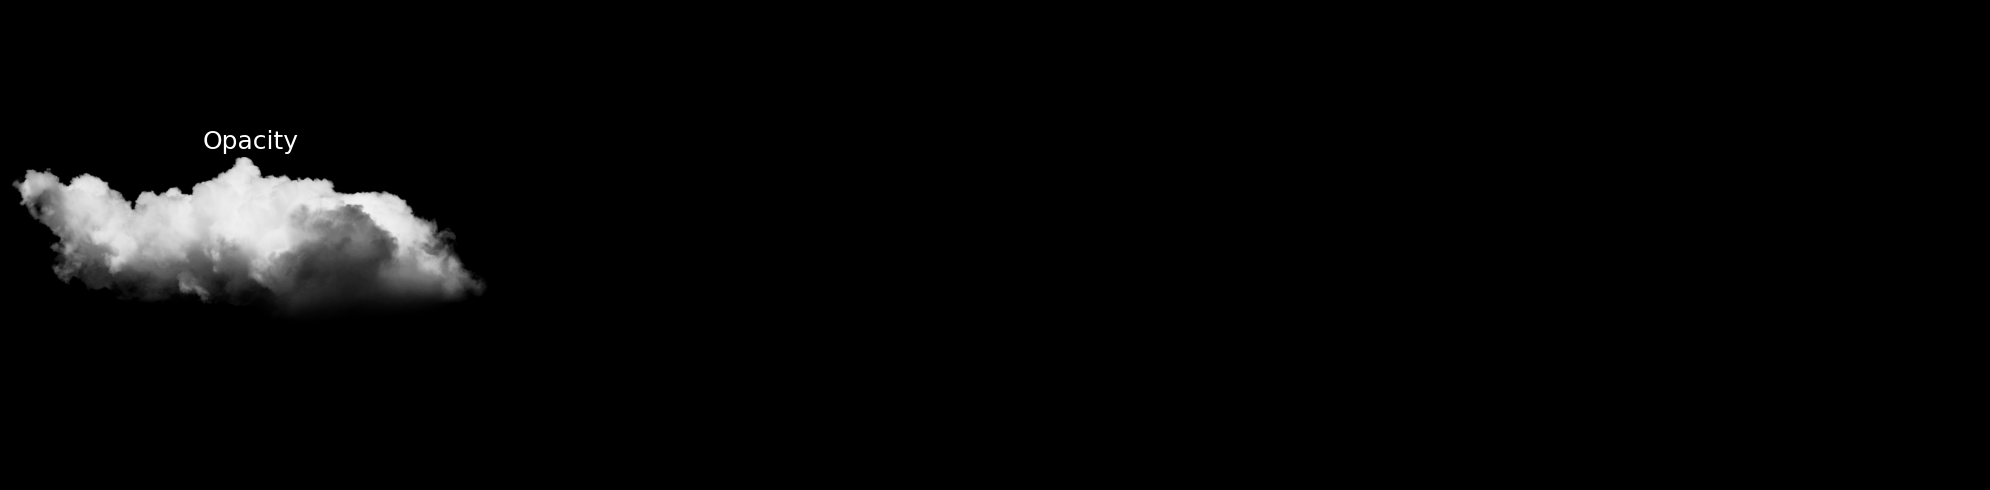

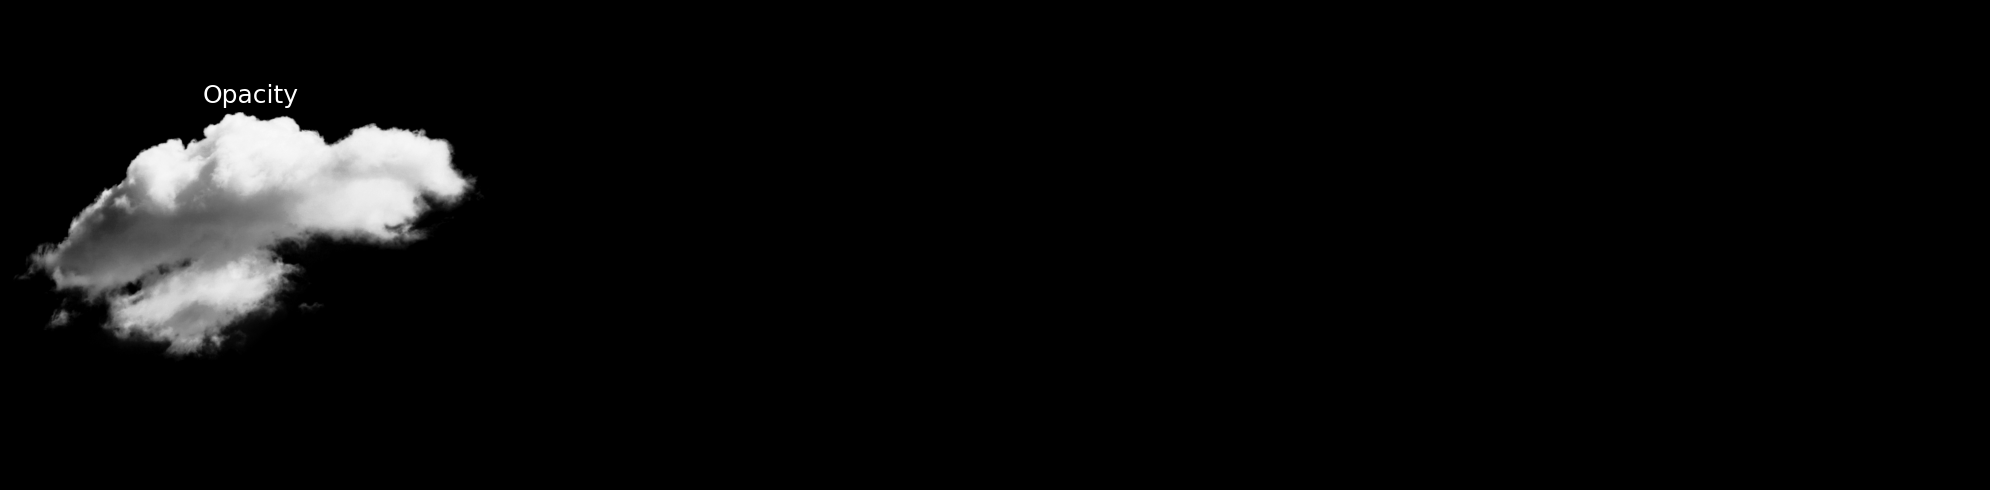

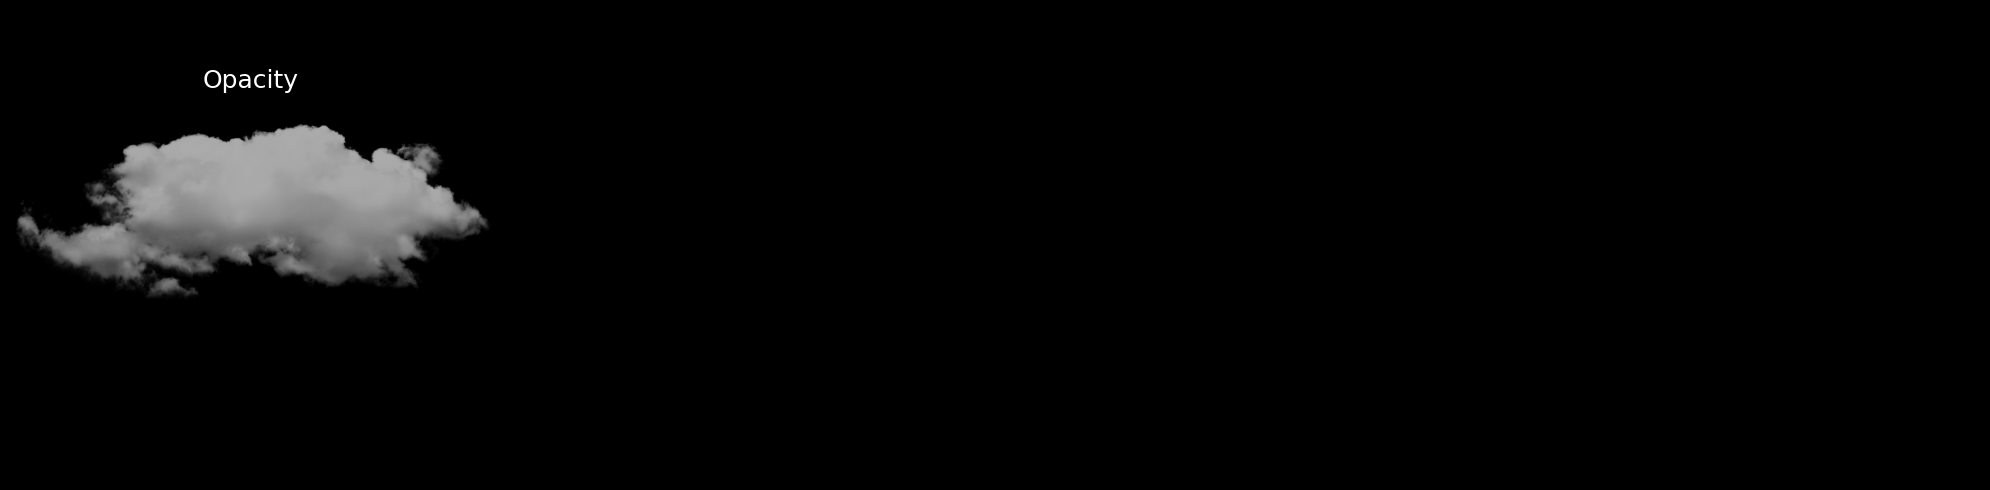

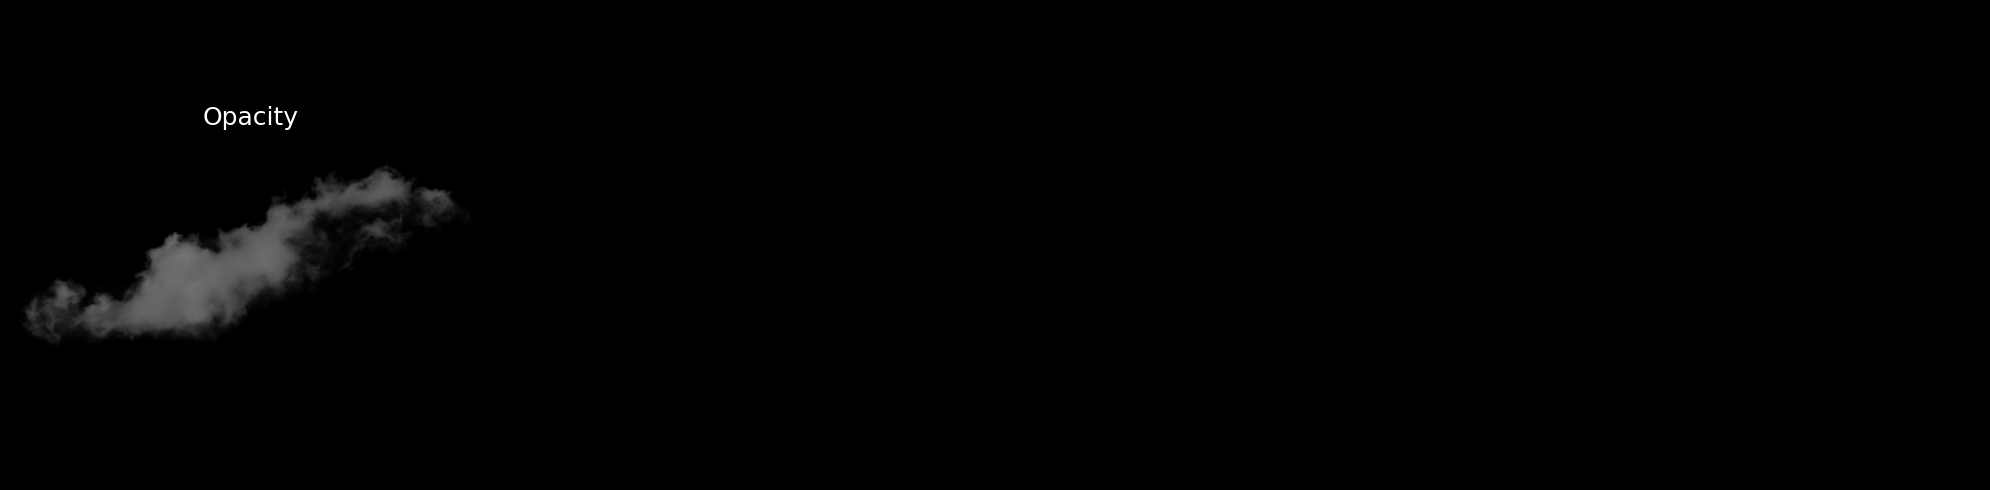

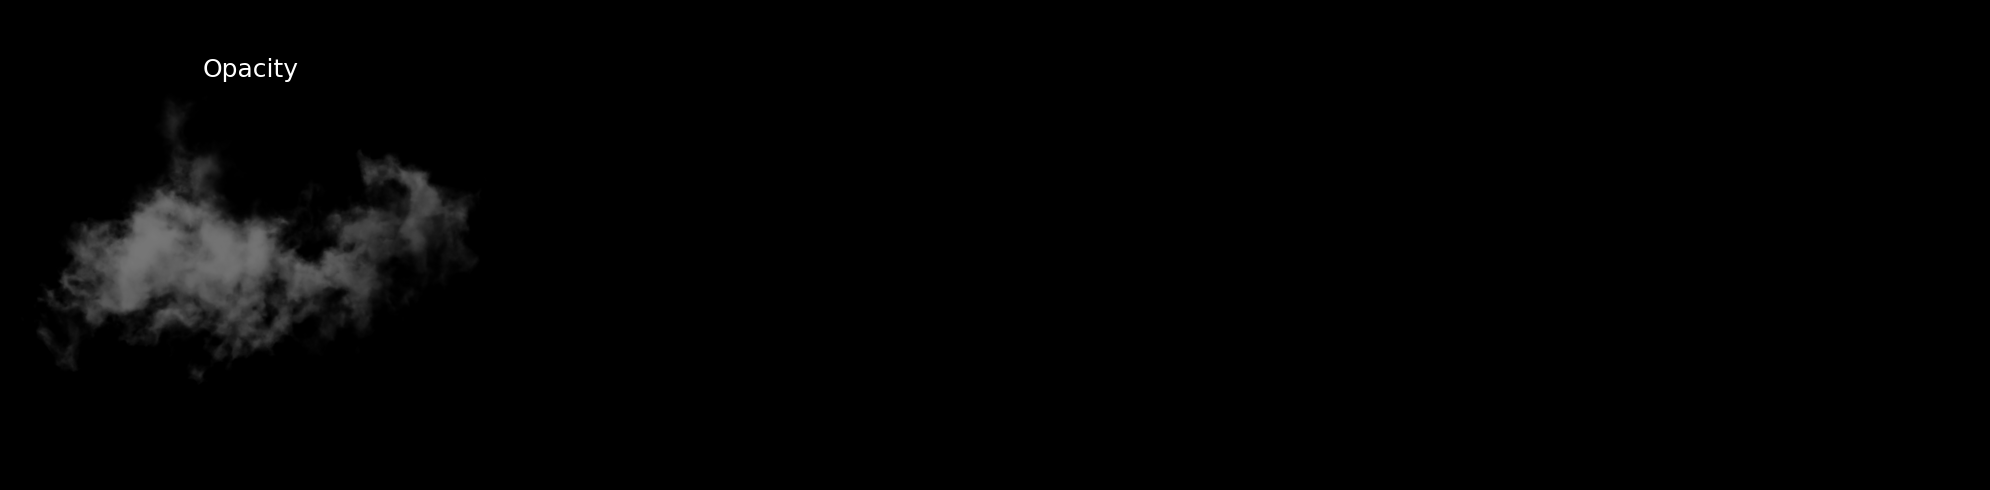

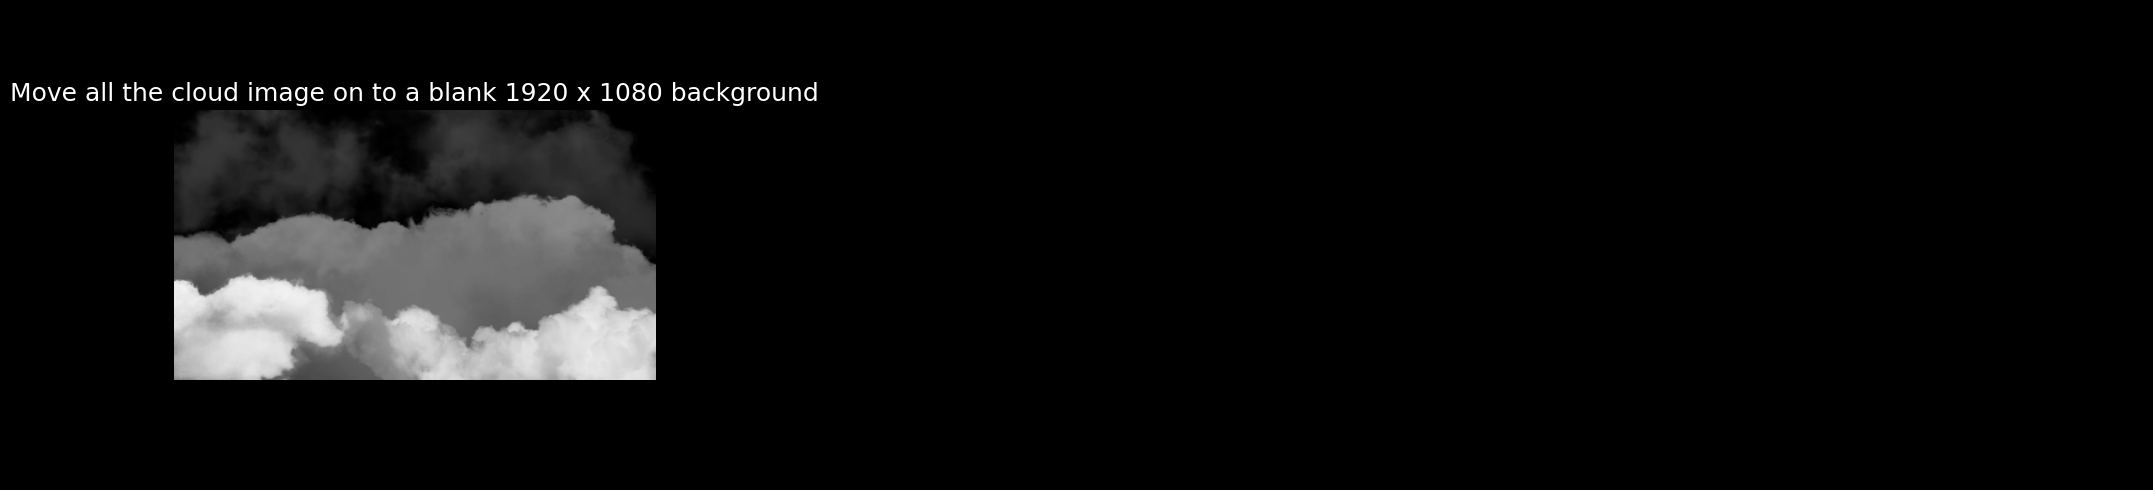

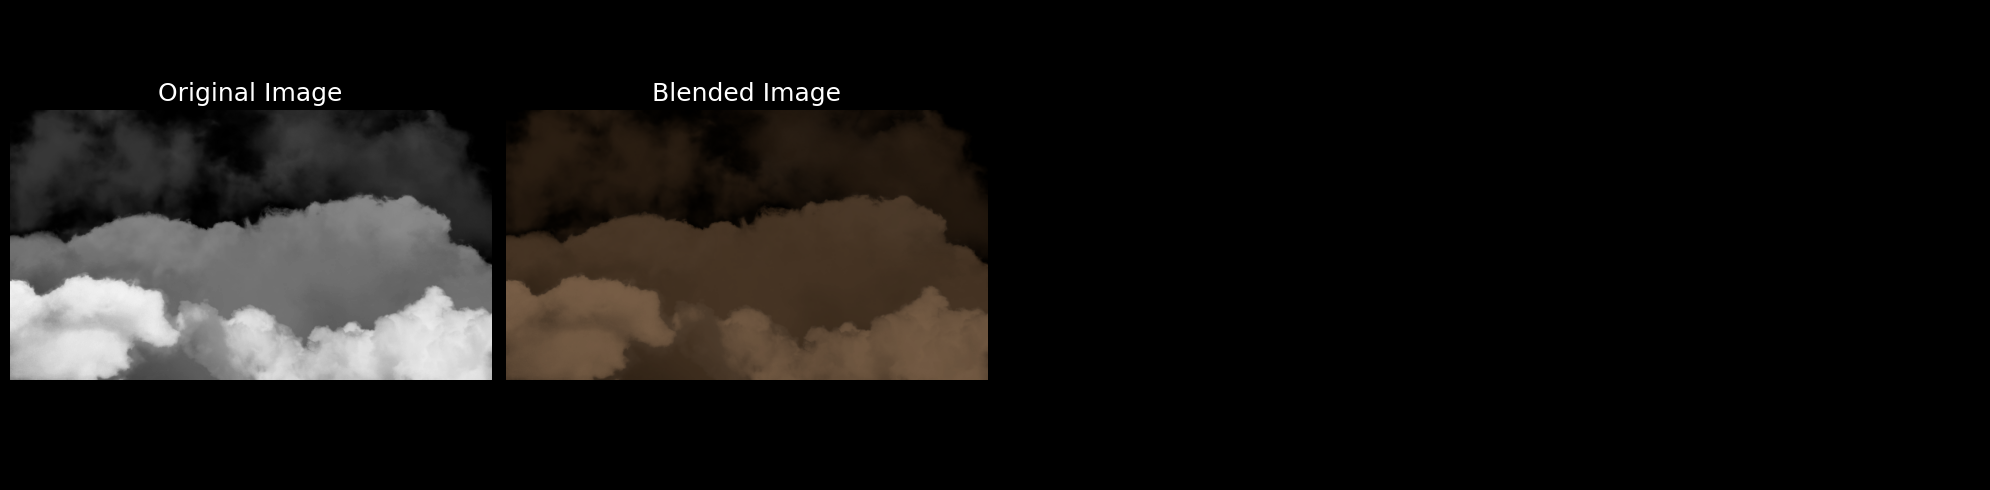

In [11]:
change_opacity("Original Picture\\03.png", "Assets\\Dustcloud\\CloudDust1.png", 1)

change_opacity("Original Picture\\06.png", "Assets\\Dustcloud\\CloudDust2.png", 1)

change_opacity("Original Picture\\28.png", "Assets\\Dustcloud\\CloudDust3.png", 0.7)

change_opacity("Original Picture\\04.png", "Assets\\Dustcloud\\CloudDust4.png", 0.5)

change_opacity("Original Picture\\91.png", "Assets\\Dustcloud\\CloudDust5.png", 0.5)

# Create a 1920x1080 transparent background
background = create_transparent_background(1920, 1080)

overlay_cloud_1 = cv2.imread("Assets\\Dustcloud\\CloudDust1.png", cv2.IMREAD_UNCHANGED)
overlay_cloud_2 = cv2.imread("Assets\\Dustcloud\\CloudDust2.png", cv2.IMREAD_UNCHANGED)
overlay_cloud_3 = cv2.imread("Assets\\Dustcloud\\CloudDust3.png", cv2.IMREAD_UNCHANGED)
overlay_cloud_4 = cv2.imread("Assets\\Dustcloud\\CloudDust4.png", cv2.IMREAD_UNCHANGED)
overlay_cloud_5 = cv2.imread("Assets\\Dustcloud\\CloudDust5.png", cv2.IMREAD_UNCHANGED)
flipped_overlay_cloud_4 = cv2.flip(overlay_cloud_4, 1)

result = overlay_images(background, overlay_cloud_1, 600, 700)
result = overlay_images(background, overlay_cloud_2, -1200, 600)
result = overlay_images(background, overlay_cloud_3, -1000, 100)
result = overlay_images(background, flipped_overlay_cloud_4, -200, -600)
result = overlay_images(background, overlay_cloud_5, -500, -600)

#For displaying in Matplot purposes
show = cv2.cvtColor(result, cv2.COLOR_BGRA2RGBA)

cv2.imwrite("Assets\\Picture1\\Dust.png", result)

displayProcess([show], ["Move all the cloud image on to a blank 1920 x 1080 background"])

apply_color_filter("Assets\\Picture1\\Dust.png", "Assets\\Picture1\\Dust.png", 
                   (41, 139, 246, 0), 0.5)

Resizing "Beach_Cyprus.png" and "old_paper.png"

In [12]:
beach = cv2.imread("Processed\\Upscale_Beach_Cyprus.png")
beach = cv2.resize(beach, (1920, 1080))

h, w, c = beach.shape
print(w, h, c, sep=",")

cv2.imwrite("Assets\\Picture2\\Beach_Cyprus.png", beach)

paper = cv2.imread("Original Picture\\old_paper.jpg")
paper = cv2.resize(paper, (1920, 1080))

h, w, c = paper.shape
print(w, h, c, sep=",")

cv2.imwrite("Assets\\old_paper.png", paper)

1920,1080,3
1920,1080,3


True

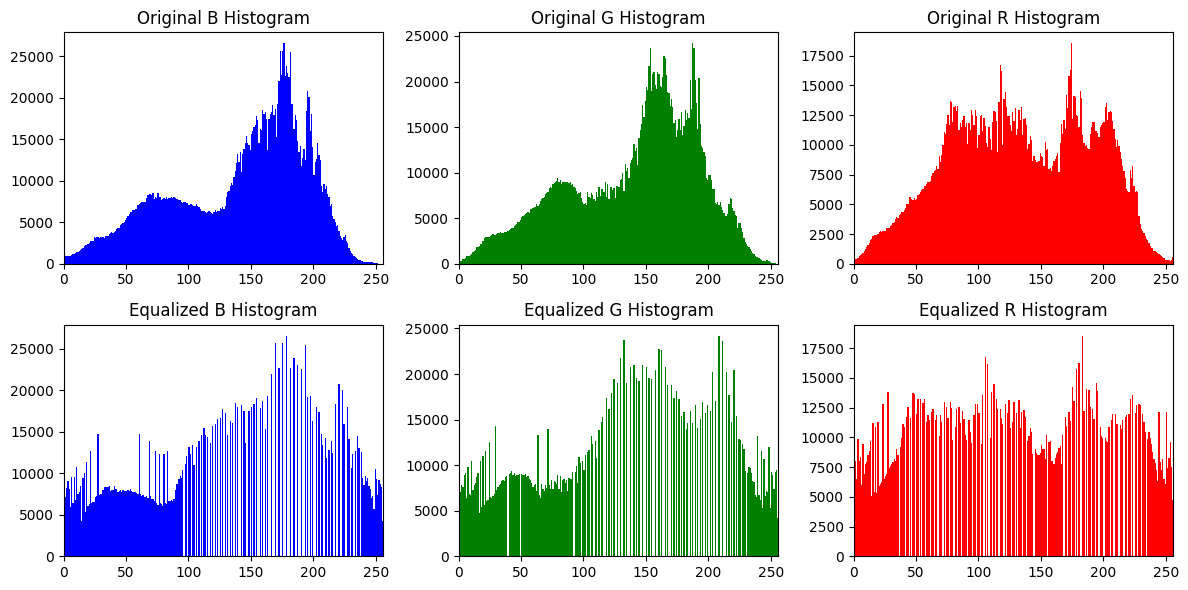

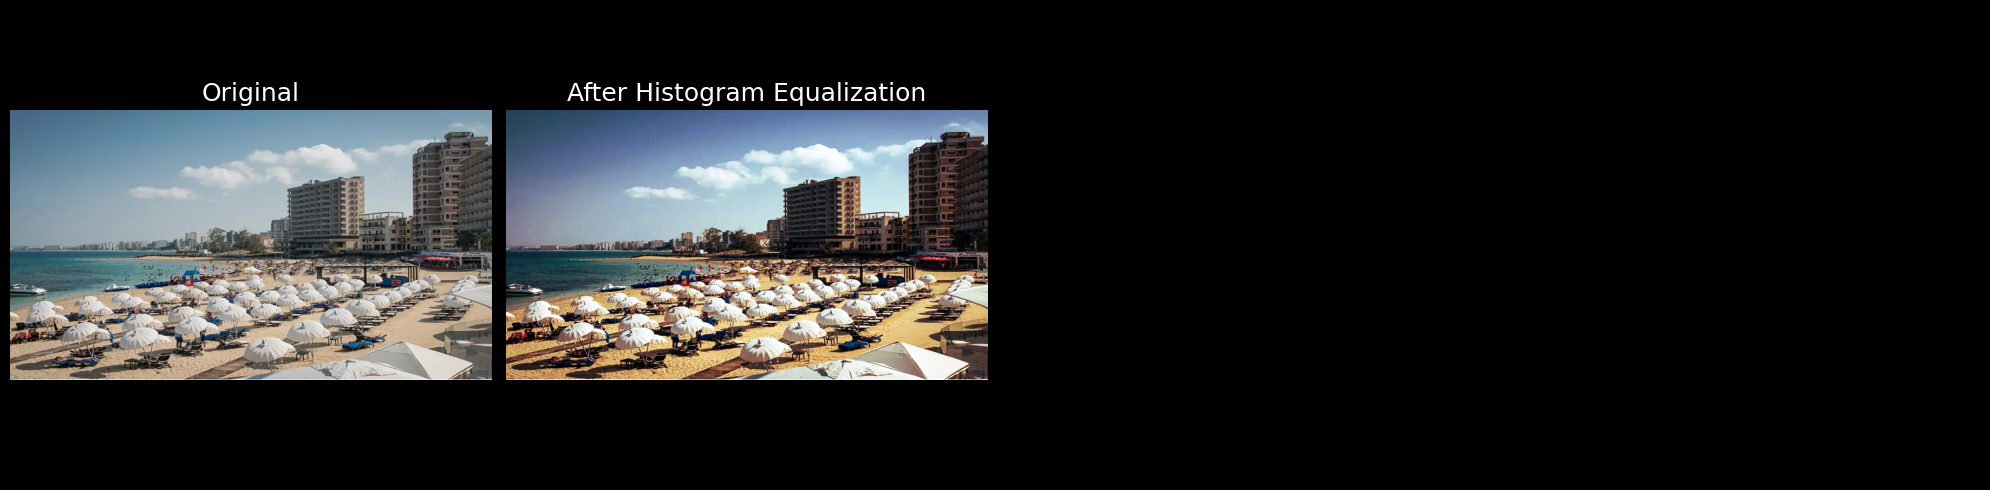

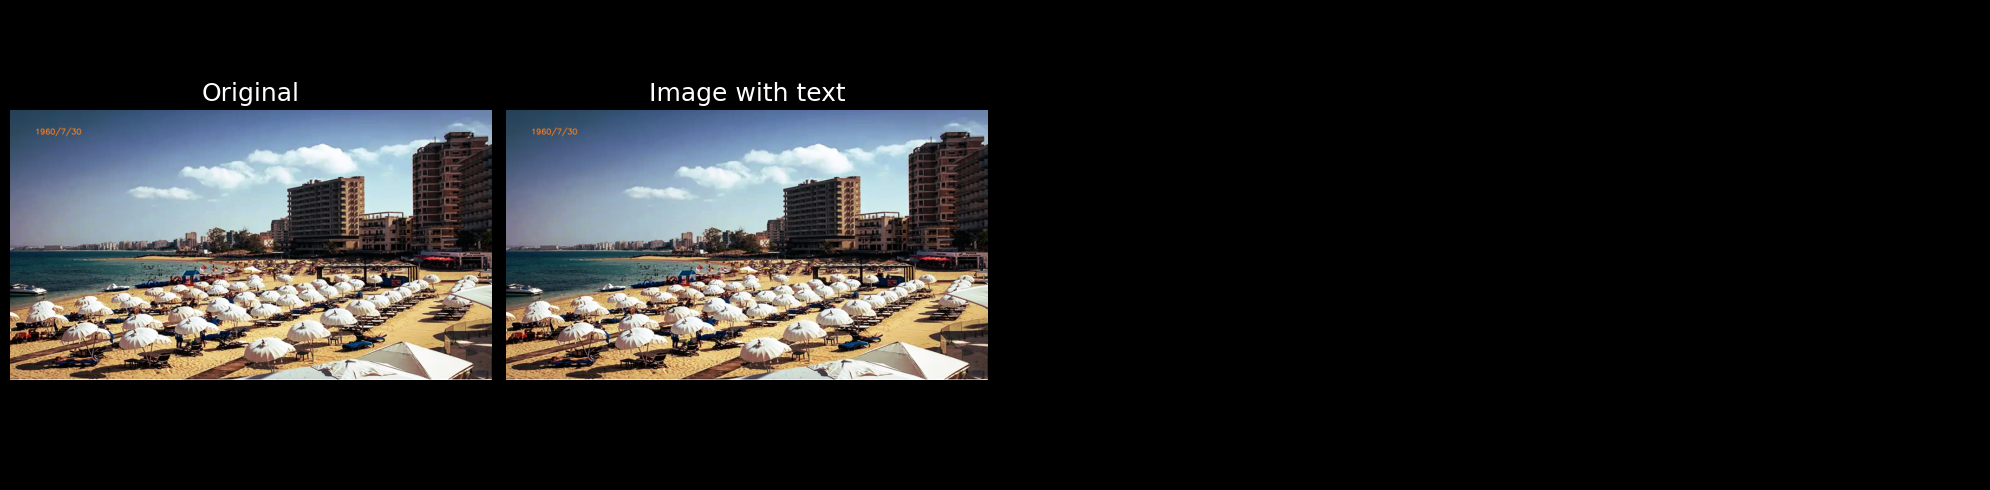

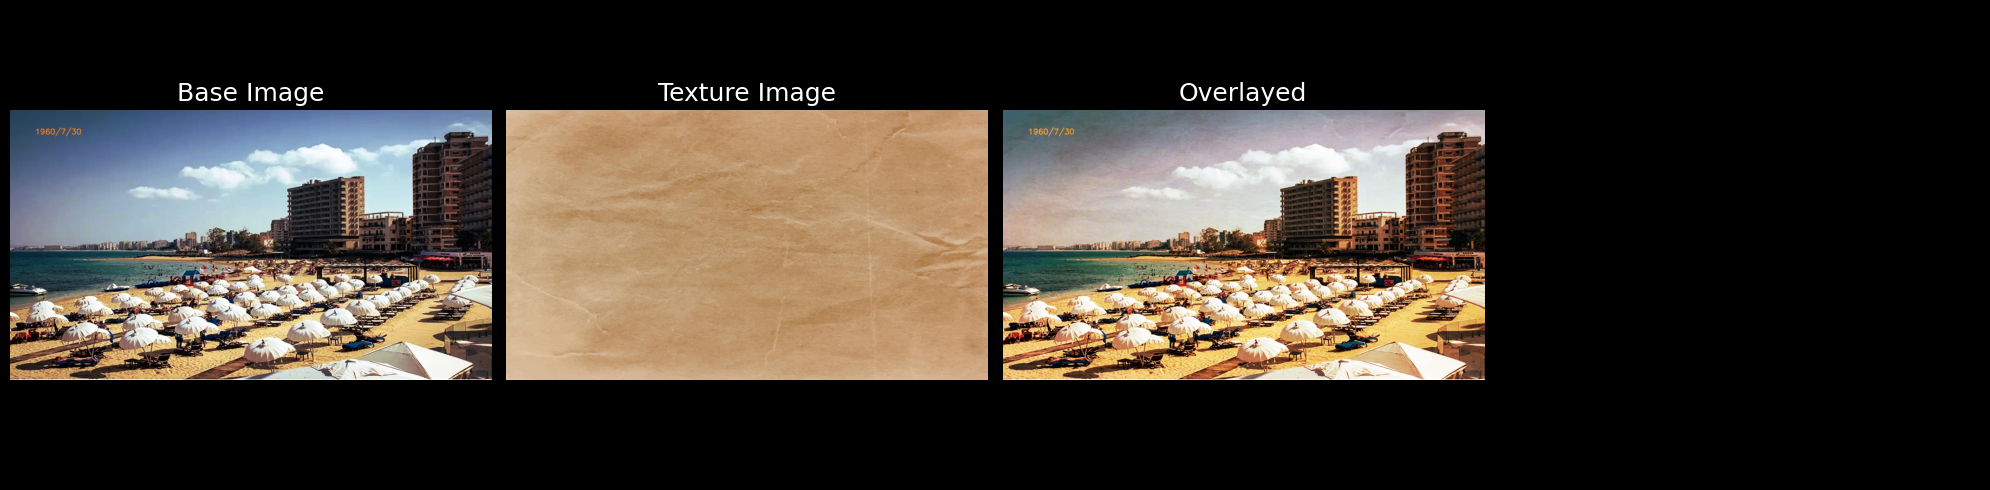

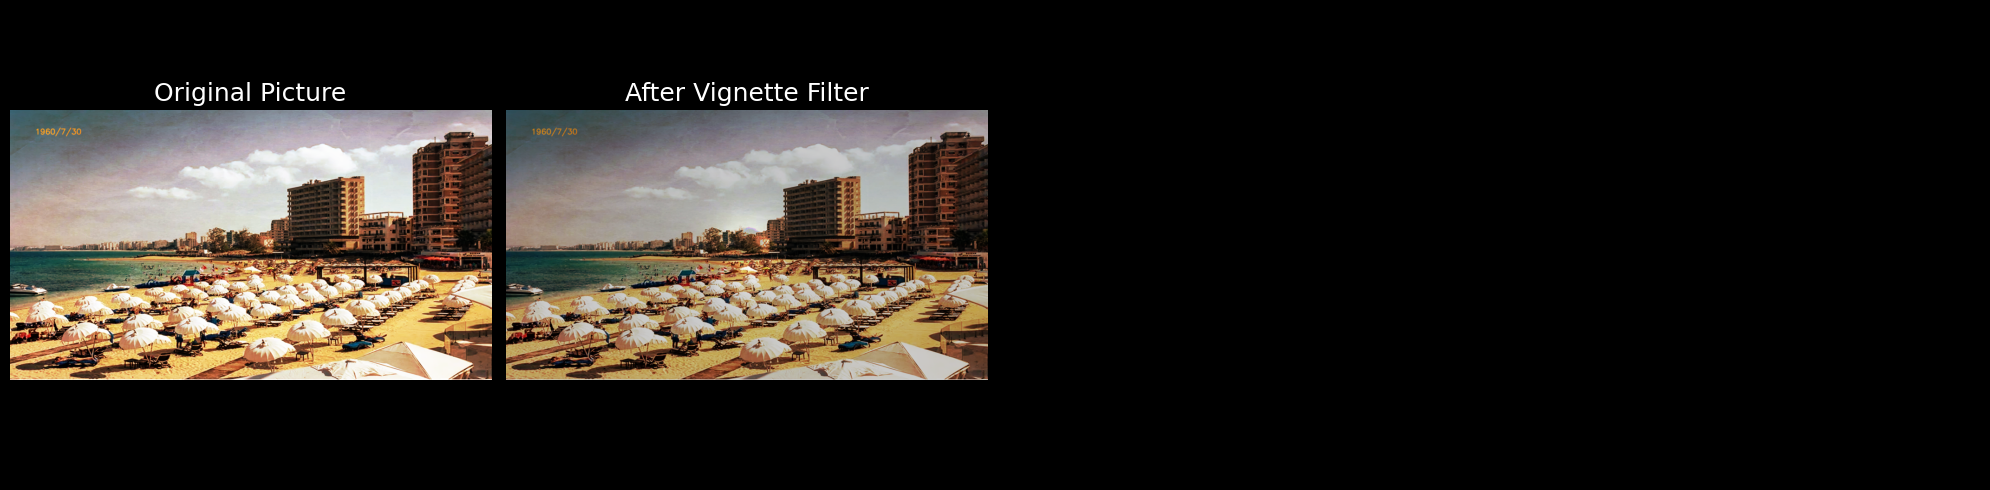

In [14]:
equalize_histogram_rgb("Assets\\Picture2\\Beach_Cyprus.png", "Assets\\Picture2\\Beach_Cyprus.png")

add_text_to_image("Assets\\Picture2\\Beach_Cyprus.png", "Assets\\Picture2\\Beach_Cyprus.png", "1960/7/30", position=(100, 100), font_color=(28, 126, 255))

texture_overlay("Assets\\Picture2\\Beach_Cyprus.png", "Assets\\old_paper.png", "Assets\\Picture2\\Beach_Cyprus.png")

add_vignette("Assets\\Picture2\\Beach_Cyprus.png", "Output\\Scene2.png", 100, 0.2)